In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from pathlib import Path

In [42]:
def moving_average(data, window_size=15):
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, max_scale=1.2):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]

    return torch.from_numpy(warped).to(torch.float32)

def add_noise_scale(data, noise_level=0.01):
    noise = torch.randn_like(data) * noise_level
    data = data + noise
    scale = np.random.uniform(0.8, 1.2)
    data = data * scale
    return data

class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
        self.aug = aug
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        X = self.X[:, start:end]
        X = moving_average(X)

        return self.augment(X), self.augment(X.clone())
        
    def augment(self, X):
        X = warp_time(X)
        X = add_noise_scale(X)
        return X

In [43]:
HZ = 100
in_channels = 6

dfs = []
for file in Path('data/elshafei_data_cleaned').iterdir():
    df = pd.read_csv(file)
    df['session_id'] = file.stem.split('_')[0]
    dfs.append(df)
df_e = pd.concat(dfs, ignore_index=True)
session_ids_e = df_e['session_id'].unique()
train_ids_e, val_ids_e = train_test_split(session_ids_e, test_size=0.2, random_state=42)

df = pd.read_csv('data/data-strom.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df = pd.concat([df, df_e], ignore_index=True)
train_ids = np.concatenate([train_ids, train_ids_e])
val_ids = np.concatenate([val_ids, val_ids_e])

df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)

winsize = 1024
forecast_size = 16

# forecast_steps = 128
# winsize_ctxt = 1024
# winsize = winsize_ctxt + forecast_steps
stride = 512
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
#     return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=True) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=False) for session_id in val_ids])

len(train_dataset), len(val_dataset)

54
1024 512


(452, 128)

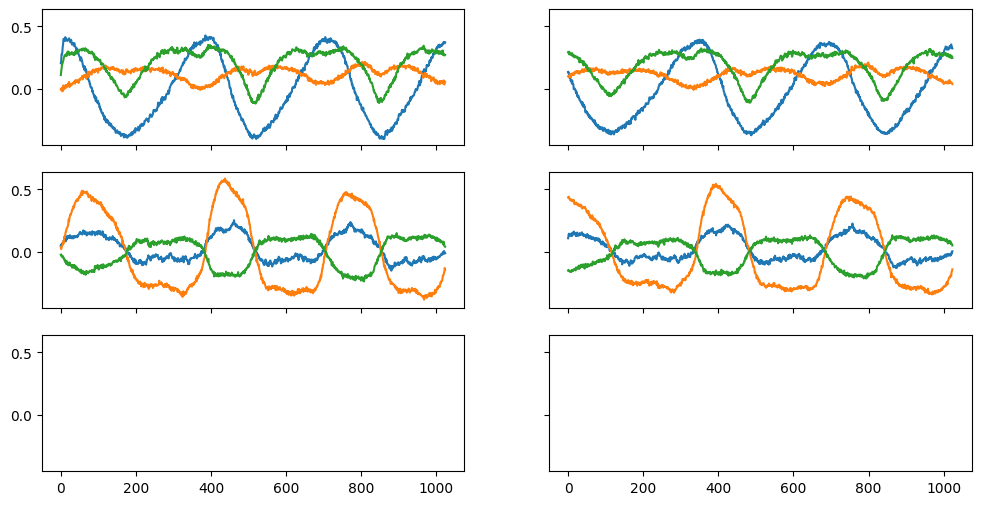

In [51]:
X1,X2 = train_dataset[1]

fig, axes = plt.subplots(3,2, sharex=True, sharey=True, figsize=(12, 6))

axes[0,0].plot(X1[0])
axes[0,0].plot(X1[1])
axes[0,0].plot(X1[2])
axes[1,0].plot(X1[3])
axes[1,0].plot(X1[4])
axes[1,0].plot(X1[5])

axes[0,1].plot(X2[0])
axes[0,1].plot(X2[1])
axes[0,1].plot(X2[2])
axes[1,1].plot(X2[3])
axes[1,1].plot(X2[4])
axes[1,1].plot(X2[5])

In [104]:
class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            ResBlock(64, 128, kernel_size=3, stride=2, dropout=0.1),
            # ResBlock(128, 128, kernel_size=3, stride=1),
            ResBlock(128, 256, kernel_size=3, stride=2, dropout=0.1),
            # ResBlock(256, 256, kernel_size=3, stride=1),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.decoder = nn.Sequential(
            # nn.Linear(256, 128),
            # nn.ReLU(),
            nn.Linear(256, forecast_size * in_channels),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x).squeeze(-1)
        x = self.decoder(x)
        return x

In [105]:
model = AutoEncoder()
device = 'cuda'
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# middle of window
forecast_slice = slice(winsize // 2 - forecast_size // 2, winsize // 2 + forecast_size // 2)
def get_masked(X):
    return torch.cat([X[:,:,:forecast_slice.start], X[:,:,forecast_slice.stop:]], dim=-1)

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

192928


In [106]:
X = next(iter(trainloader))
model(X.to(device)).shape

torch.Size([128, 96])

In [107]:
def train(model, epochs=10, outfile='best_model.pth'):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        train_loss = 0.0
        for X in trainloader:
            X = X.to(device)
            optimizer.zero_grad()
            Xpred = model(get_masked(X)).view(X.size(0), in_channels, forecast_size)
            loss = criterion(Xpred, X[:,:,forecast_slice])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(trainloader)
        train_losses.append(train_loss)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X in valloader:
                X = X.to(device)
                Xpred = model(get_masked(X)).view(X.size(0), in_channels, forecast_size)
                loss = criterion(Xpred, X[:,:,forecast_slice])
                val_loss += loss.item()
            val_loss /= len(valloader)
            val_losses.append(val_loss)    

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), outfile)
            print(f"*Epoch {epoch+1}/{epochs}, Loss: {train_loss:.07f}, Val Loss: {val_loss:.07f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.07f}, Val Loss: {val_loss:.07f}")

        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.savefig('loss.png')
        plt.legend()
        plt.close()

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()
    

In [ ]:
train(model, epochs=100, outfile='best_model2.pth')

*Epoch 1/100, Loss: 0.7430984, Val Loss: 0.7688423
*Epoch 2/100, Loss: 0.7331004, Val Loss: 0.7540183
*Epoch 3/100, Loss: 0.7126331, Val Loss: 0.7052783
*Epoch 4/100, Loss: 0.6417325, Val Loss: 0.6097904
*Epoch 5/100, Loss: 0.5135187, Val Loss: 0.4848440
*Epoch 6/100, Loss: 0.3732579, Val Loss: 0.4046493
*Epoch 7/100, Loss: 0.2956049, Val Loss: 0.2811721
*Epoch 8/100, Loss: 0.1673381, Val Loss: 0.1354195
*Epoch 9/100, Loss: 0.0765529, Val Loss: 0.0835727
*Epoch 10/100, Loss: 0.0480547, Val Loss: 0.0699238
*Epoch 11/100, Loss: 0.0347757, Val Loss: 0.0468738
*Epoch 12/100, Loss: 0.0257771, Val Loss: 0.0454870
*Epoch 13/100, Loss: 0.0206236, Val Loss: 0.0334579
*Epoch 14/100, Loss: 0.0166364, Val Loss: 0.0280237
Epoch 15/100, Loss: 0.0139167, Val Loss: 0.0347094
*Epoch 16/100, Loss: 0.0119387, Val Loss: 0.0192386


<Axes: >

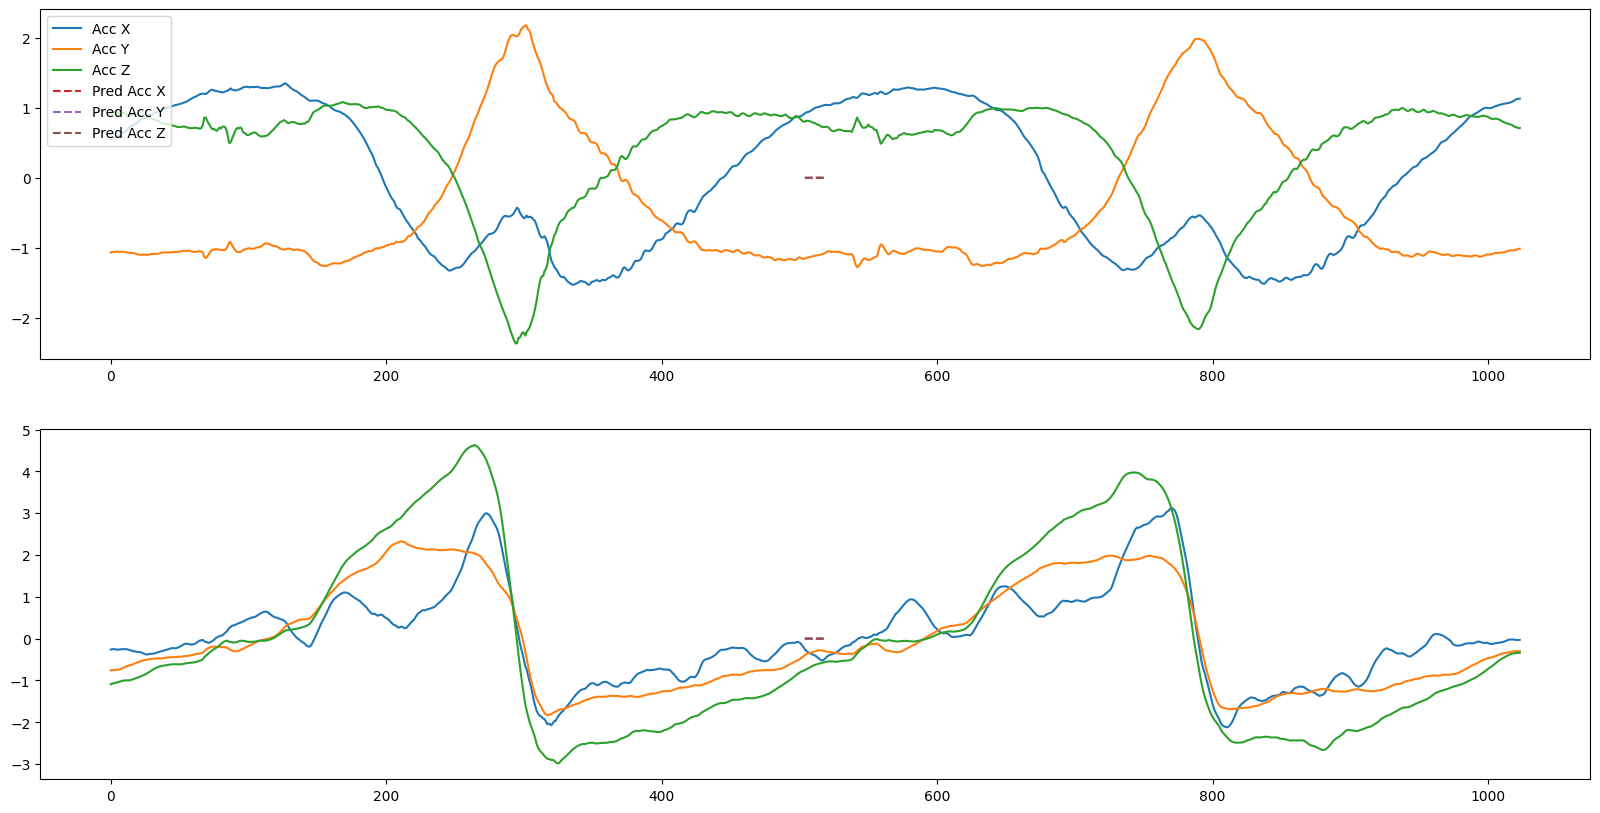

In [103]:
# 256-16: 0.04 - follows trend
# 256-32: 0.06 - follows trend
# 256-32 smoothed: 0.02 - looks decent - lot of mistakes
# model.load_state_dict(torch.load('best_model2.pth'))
model.eval()
X = trainloader.dataset[2000].unsqueeze(0)
# X = valloader.dataset[250].unsqueeze(0)
X = X.to(device)
model.eval()
with torch.no_grad():
    Xpred = model(get_masked(X)).cpu().view(X.size(0), in_channels, forecast_size)

i=0
fig, axes = plt.subplots(2,1,figsize=(20, 10))
plt.subplot(2, 1, 1)
axes[0].plot(X[i,0].cpu(), label='Acc X')
axes[0].plot(X[i,1].cpu(), label='Acc Y')
axes[0].plot(X[i,2].cpu(), label='Acc Z')
axes[1].plot(X[i,3].cpu(), label='Gyr X')
axes[1].plot(X[i,4].cpu(), label='Gyr Y')
axes[1].plot(X[i,5].cpu(), label='Gyr Z')


axes[0].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,0], label='Pred Acc X', linestyle='--')
axes[0].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,1], label='Pred Acc Y', linestyle='--')
axes[0].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,2], label='Pred Acc Z', linestyle='--')
axes[1].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,3], label='Pred Gyr X', linestyle='--')
axes[1].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,4], label='Pred Gyr Y', linestyle='--')
axes[1].plot(np.arange(forecast_slice.start, forecast_slice.stop), Xpred[i,5], label='Pred Gyr Z', linestyle='--')

plt.legend(loc='upper left')
axes[0]#.set_xlim(350, 544)
axes[1]#.set_xlim(350, 544)

In [1]:
# loss < 0.0000 perfect
# loss = 0.0000167 perfect
# loss = 0.0000395 perfect
model.load_state_dict(torch.load('best_model.pth'))
X = next(iter(valloader))
model.eval()
with torch.no_grad():
    Xpred = model(X.to(device)).cpu()

i = 1
j = slice(None, None)
fig,axes = plt.subplots(2,1,figsize=(10, 5))
axes[0].plot(X[i, 0,j].numpy(), label='acc_x')
axes[0].plot(Xpred[i, 0,j].numpy(), label='acc_x_pred', linestyle='--')
axes[0].plot(X[i, 1,j].numpy(), label='acc_y')
axes[0].plot(Xpred[i, 1,j].numpy(), label='acc_y_pred', linestyle='--')
axes[0].plot(X[i, 2,j].numpy(), label='acc_z')
axes[0].plot(Xpred[i, 2,j].numpy(), label='acc_z_pred', linestyle='--')
axes[1].plot(X[i, 3,j].numpy(), label='gyr_x')
axes[1].plot(Xpred[i, 3,j].numpy(), label='gyr_x_pred', linestyle='--')
axes[1].plot(X[i, 4,j].numpy(), label='gyr_y')
axes[1].plot(Xpred[i, 4,j].numpy(), label='gyr_y_pred', linestyle='--')
axes[1].plot(X[i, 5,j].numpy(), label='gyr_z')
axes[1].plot(Xpred[i, 5,j].numpy(), label='gyr_z_pred', linestyle='--')
axes[0].legend()
axes[1].legend()

NameError: name 'model' is not defined